In [50]:
import spikeextractors as se
import spiketoolkit as st
import spikewidgets as sw
import edlio
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [33]:
ced_file = "/Users/abuccino/Documents/Data/catalyst/heidelberg/ced/Short_example/M113_C4.smrx"

## Load TTL signals and extract triggers

In [111]:
channel_info = se.CEDRecordingExtractor.get_all_channels_info(ced_file)

In [ ]:
smrx_channels = []
for ch, info in channel_info.items():
    if 'TTL' in info["title"]:
        print("Loading", info["title"])
        smrx_channels.append(ch)

rec = se.CEDRecordingExtractor(ced_file, smrx_channels)

In [100]:
traces = rec.get_traces()

<IPython.core.display.Javascript object>


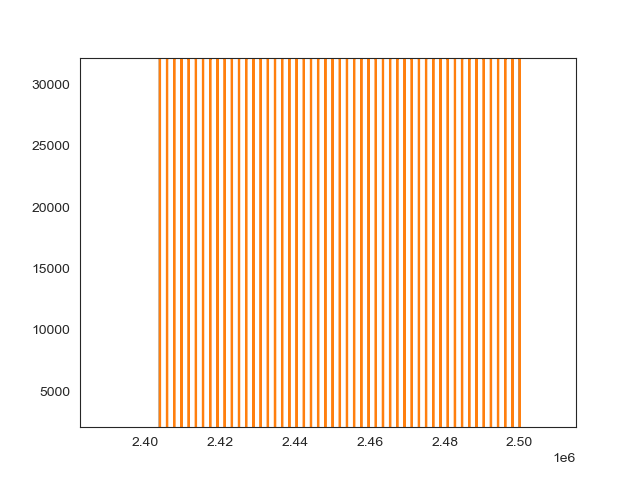

In [101]:
plt.figure()
plt.plot(traces.T)

### Find rising and falling edges

In [102]:
ttls = []
states = []
for tr in traces:
    threshold = np.ptp(tr) / 2 + np.min(tr)
    crossings = np.array(tr > threshold).astype('int8')
    
    rising = np.nonzero(np.diff(crossings, 1) > 0)[0]
    falling = np.nonzero(np.diff(crossings, 1) < 0)[0]
    
    ttl = np.concatenate((rising, falling))
    sort_order = np.argsort(ttl)
    ttl = np.sort(ttl)
    state = [1] * len(rising) + [-1] * len(falling)
    state = np.array(state)[sort_order]

    ttls.append(ttl)
    states.append(state)

<IPython.core.display.Javascript object>


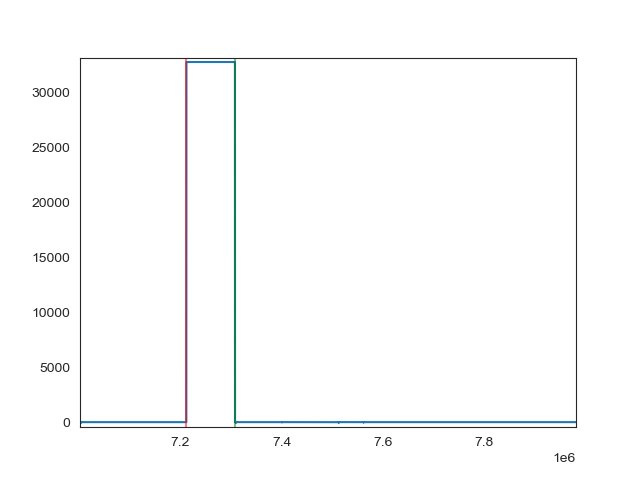

<IPython.core.display.Javascript object>


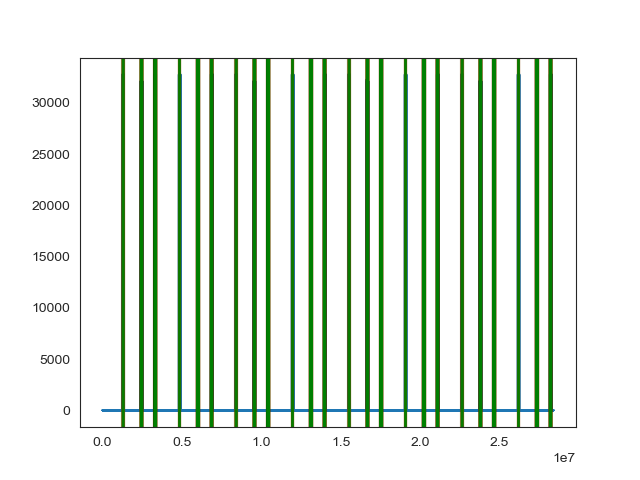

In [105]:
# plot 
for i, tr in enumerate(traces):
    fig, ax = plt.subplots()
    
    ax.plot(tr)
    state = states[i]
    ttl = ttls[i]
    
    for t in ttl[state == 1]:
        plt.axvline(t, color='r', alpha=0.5)
    for t in ttl[state == -1]:
        plt.axvline(t, color='g', alpha=0.5)

The `Conditions` in the mat files are just the TTLs with rising and falling in the same row:

In [108]:
conditions = []

for ttl, state in zip(ttls, states):
    assert len(ttl[state==1]) == len(ttl[state==-1]), "Different number of rising/falling edges"
    condition = np.zeros((len(ttl[state==1]), 2), dtype='int')
    
    condition[:, 0] = ttl[state == 1]
    condition[:, 1] = ttl[state == -1]
    
    conditions.append(condition)

In [110]:
conditions[0]

array([[   96153,   192307],
       [ 1249999,  1346153],
       [ 2403845,  2499999],
       [ 3653845,  3749999],
       [ 4807692,  4903845],
       [ 5961538,  6057692],
       [ 7211538,  7307692],
       [ 8365384,  8461538],
       [ 9519230,  9615384],
       [10769230, 10865384],
       [11923076, 12019230],
       [13076922, 13173076],
       [14326922, 14423076],
       [15480768, 15576922],
       [16634615, 16730768],
       [17884615, 17980768],
       [19038461, 19134615],
       [20192307, 20288461],
       [21442307, 21538461],
       [22596153, 22692307],
       [23749999, 23846153],
       [24999999, 25096153],
       [26153845, 26249999],
       [27307692, 27403845]])

## Save other signals to NWB

Non-TTL signals can be saved normally to NWB (note that Keyboard is somehow problematic...).

Also we can only load traces with the same sampling frequency in the same extractor.

In [122]:
smrx_channels = []
smrx_channels_names = []

sampling_rate_limit = 15000

for ch, info in channel_info.items():
    if 'TTL' not in info["title"] and info["title"] != 'Keyboard':
        if info['rate'] > sampling_rate_limit:
            print("Loading", info["title"])
            smrx_channels.append(ch)
            smrx_channels_names.append(info["title"])
        else:
            print("Skipped", info["title"])
            print(info)

rec = se.CEDRecordingExtractor(ced_file, smrx_channels)

Loading Touch
Loading Temp
Loading Mechsti
Loading 10 Vm
Loading F_10Vm
Loading L6 LFP
Skipped Spikes
{'type': <DataType.EventRise: 3>, 'ch_number': -1, 'title': 'Spikes', 'rate': 6.971646134055971, 'max_time': 738324808, 'divide': 1, 'time_base': 2e-06, 'scale': 1.0, 'offset': 0.0, 'unit': '', 'y_range': (-1.0, 1.0), 'comment': 'No comment', 'size_bytes:': 65536}
Skipped Control
{'type': <DataType.EventRise: 3>, 'ch_number': -1, 'title': 'Control', 'rate': 0.010777521236505135, 'max_time': 650000018, 'divide': 1, 'time_base': 2e-06, 'scale': 1.0, 'offset': 0.0, 'unit': '', 'y_range': (-1.0, 1.0), 'comment': 'No comment', 'size_bytes:': 65536}
Skipped 1Hz
{'type': <DataType.EventRise: 3>, 'ch_number': -1, 'title': '1Hz', 'rate': 0.010777521236505135, 'max_time': 680000014, 'divide': 1, 'time_base': 2e-06, 'scale': 1.0, 'offset': 0.0, 'unit': '', 'y_range': (-1.0, 1.0), 'comment': 'No comment', 'size_bytes:': 65536}
Skipped 10Hz
{'type': <DataType.EventRise: 3>, 'ch_number': -1, 'title'

<IPython.core.display.Javascript object>


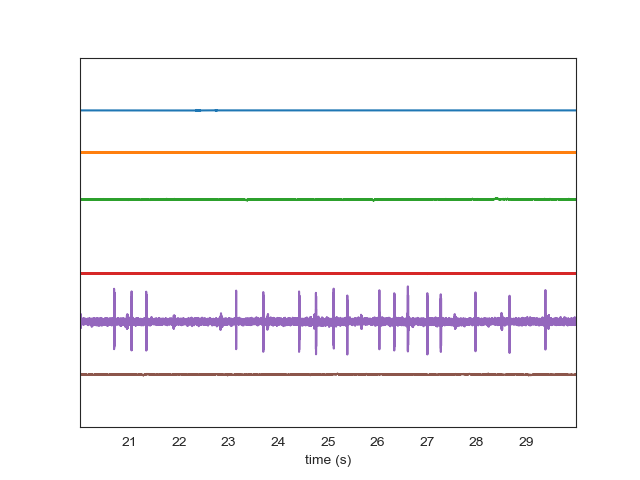

In [119]:
sw.plot_timeseries(rec, trange=[20, 30])

These can be saved directly as ElectricalSeries to NWB.